###Installation & Imports

In [1]:
from google.colab import drive
#Mount google drive for retrive files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece
!pip install emoji
!pip install emot
!pip install nltk

     |████████████████████████████████| 1.2MB 15.2MB/s 
     |████████████████████████████████| 133kB 14.7MB/s 


In [3]:
from fastai.text import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

from nltk.corpus import words
from bs4 import BeautifulSoup
import nltk
nltk.download('words')
import nltk, string, re, spacy,unicodedata, random
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.61', '1.9.0+cu102')

In [5]:
torch.cuda.set_device(0)

In [6]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [7]:
random_seed(42, True)

In [8]:
path = Path('/tmp')

In [9]:
!pwd

/content


###Import Data

In [10]:
df_train = pd.read_csv('/content/drive/My Drive/TASME/data/tamil_offensive_full_train.csv', sep=',', header=None)
df_train = df_train.dropna()
df_train = df_train[[1,0]]
df_train

,1,0
0,Not_offensive,movie vara level la Erika poguthu
1,not-Tamil,I love Ajith Kumar Vivegam movie inki mjy bht ...
2,Not_offensive,Padam nalla comedy padama irukum polaye..
3,Not_offensive,karthick subburaj anne .... intha padam vetri ...
4,Not_offensive,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁
...,...,...
35134,Not_offensive,Trending number #2 idhukku nammalam karanamnu ...
35135,Not_offensive,"Movie script super, athuvum HIP HOP Tamizha mu..."
35136,Not_offensive,Just 3k likes for 300k likes
35137,not-Tamil,Aaloo le lo. Kanda le lo.


In [11]:
print(len(df_train))

35139


In [12]:
df_valid = pd.read_csv('/content/drive/My Drive/TASME/data/tamil_offensive_full_dev.csv', sep=',', header=None)
df_valid = df_valid.dropna()
df_valid = df_valid[[1,0]]
df_valid

,1,0
0,Not_offensive,Handsome hunk keri vaa thalaivaa
1,Not_offensive,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...
2,not-Tamil,je vous aime bravo pour clip de merde que j éc...
3,Not_offensive,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...
4,Not_offensive,Vera level BGM .. semma trailer. 🤞
...,...,...
4383,Not_offensive,மிஷ்கின் - சினிமாவின் சலித்து போன வட்டத்திற்க...
4384,Not_offensive,Sivaji - Bhajii Sapdu Petta - Sweet Sapdu Ser...
4385,Offensive_Targeted_Insult_Other,8k dislike sure all vijay fans
4386,Not_offensive,Lady super star Manju warrier Fans Hit like


In [13]:
df_test = pd.read_csv('/content/drive/My Drive/TASME/data/tamil_offensive_full_test_with_labels.csv', sep=',', header=None)
df_test = df_test.dropna()
df_test = df_test[[1,0]]
df_test

,1,0
0,Not_offensive,14.12.2018 epo trailer pathutu irken ... Semay...
1,Not_offensive,Paka thana poro movie la Enna irukunu
2,not-Tamil,“U kena tunggu lebih lama lagi untuk tahu saya...
3,Not_offensive,Suriya anna vera level anna mass
4,Offensive_Untargetede,suma kaththaatha da sound over a pooda kudaath...
...,...,...
4387,Offensive_Targeted_Insult_Group,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...
4388,not-Tamil,Babu mele ko ye song sunke kuch yesa feel hua ...
4389,Not_offensive,asuran= aadukalam+pudupettai+ wada chennai..ye...
4390,Not_offensive,Vijay's all movies look like same.


###Preprocessing

In [14]:
def deEmojify(string):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)

def preprocess(text):
  text = deEmojify(text) #convert emojis to their defns in words, they might be useful
  text = re.sub(r'([\.\'\"\/\-\_\--])',' ', text) # remove punctuations , removes @USER / some abbreviatins
  to_remove_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
      '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  text = re.sub(to_remove_url,'',text)  # remove url patterns
  text = re.sub(" \d+", " ", text)
  text = text.replace(","," ")
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  punctuation='!!"$%&()*+-/:;<=>?[\\]^_{|}~.'
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  # text = text.translate(str.maketrans('', '', string.punctuation))
  text = BeautifulSoup(text, 'html.parser').get_text()
    # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  text = ' '.join(ch for ch in tokens)
  return text 

def clean(df):
  df[1] = df[1].apply(lambda x: preprocess(x))

clean(df_train)
clean(df_valid)
clean(df_test)

###Model

In [15]:
df_train.shape, df_valid.shape, df_test.shape

((35139, 2), (4388, 2), (4391, 2))

In [16]:
df_train[df_train[0].isnull()].shape, df_valid[df_valid[0].isnull()].shape, df_test[df_test[0].isnull()].shape

((0, 2), (0, 2), (0, 2))

In [17]:
class TamilTokenizer(BaseTokenizer):    
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str('/content/drive/My Drive/TASME/tokenizer/tamil_spm_8k.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str('/content/drive/My Drive/TASME/tokenizer/tamil_spm_8k.model'))
itos = [sp.IdToPiece(int(i)) for i in range(8000)]

In [19]:
tamil_vocab = Vocab(itos)

In [20]:
tokenizer = Tokenizer(tok_func=TamilTokenizer, lang='ta')

In [21]:
label_cols = [0]

In [22]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, test_df=df_test, tokenizer=tokenizer, vocab=tamil_vocab)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [23]:
data_lm.show_batch()

idx,text
0,<unk> ▁p ad am ▁n al la ▁ com ed y ▁p ad am a ▁ ir uk um ▁p ol ay e . . ▁ x x b os ▁ k ar th ick ▁s ub b ur aj ▁ an ne ▁ x x re p ▁4 ▁ . ▁ int ha ▁p ad am ▁ ve tri ▁ ad ay a ▁ un ag al uk k
1,am a ▁a am a . . s up er ▁ ed it ▁ ; ) ▁ x x b os ▁ y u van <unk> ▁b g m ▁s em ma ▁m ass ▁a ha ▁ ir uk k u . . . ▁ x x b os ▁ v ar um ▁ th ir ai ▁ y ang um ▁ et uth ik k um ▁p ay av
2,நா னும் ▁படம் ▁பார்க்க ▁ஆ வல ோடு ▁இருக்க ேன் . ▁ x x b os ▁ <unk> th at ▁ g u y : i pp a ▁n am ma ▁ en na ▁p an na ▁p or om ? ? <unk> <unk> ha la iv ar : s we et ▁ sa ap id a ▁p or om . . . <unk> <unk> er a ▁l ev el .
3,▁ ah ▁p a ak a ▁m udi la ▁ x x b os <unk> <unk> d uk u ▁ d is li ke ▁p an ra van <unk> <unk> la ▁ k and ip a ▁ v ill age ▁m ov ie ▁m at um ▁ d a <unk> ▁n al a ▁m ov ie ▁ ni na ip av an ▁ ah ▁ ir up an <unk> <unk>
4,d a a ▁ x x b os ▁1 : 00 ▁m y ▁f av ▁b g m it s ▁ k ill ing ▁ x x re p ▁4 ▁ . ▁ x x b os ▁தீ ரன் ▁சின்ன மலை கவுண்ட ர் ▁பேரவை யின் ▁சார்பாக ▁படம் ▁வெற்றி ய டைய ▁வாழ் த்து க ிறோம் ▁ x x b os <unk> <unk> ru ▁ ve la <unk> ▁s hi va <unk>


In [24]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [25]:
learn.load('/content/drive/My Drive/TASME/model/wikitalm_8k_447_third')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (35139 items)
x: LMTextList
▁ x x b os ▁m ov ie ▁ va ra ▁l ev el ▁ la <unk> <unk> ri ka ▁p og uth u,▁ x x b os <unk> <unk> ▁ lo ve <unk> ▁a j ith <unk> <unk> um ar <unk> <unk> ive g am ▁m ov ie ▁in k i ▁m j y ▁b h t ▁ ach i ▁l g i,▁ x x b os <unk> ▁p ad am ▁n al la ▁ com ed y ▁p ad am a ▁ ir uk um ▁p ol ay e . .,▁ x x b os ▁ k ar th ick ▁s ub b ur aj ▁ an ne ▁ x x re p ▁4 ▁ . ▁ int ha ▁p ad am ▁ ve tri ▁ ad ay a ▁ un ag al uk k u ▁ en n ud ay a ▁ v al th uk k al . . .,▁ x x b os ▁கவு ண்டர் ▁தேவர் . சார் பா க ▁வெற்றி ▁பெற ▁வாழ் த்துக் கள் ▁ <unk>
y: LMLabelList
,,,,
Path: /tmp;

Valid: LabelList (4388 items)
x: LMTextList
▁ x x b os <unk> <unk> and s ome ▁ h un k ▁ ke ri ▁ va a ▁ th al ai va a,▁ x x b os ▁தென்காசி ▁மாவட்டம் ▁நாட ார் ▁சமுதாய ம் ▁சார்பாக ▁வாழ் த்துக் கள்,▁ x x b os ▁ j e ▁ v ous ▁ ai me ▁ br av o ▁p our ▁ cl ip ▁de ▁m er de ▁ <unk> ue ▁ j ▁ <unk> co ut e ▁a u ▁to il et te .,▁ x x b os ▁சிறப்பு ▁ x x re p ▁5 ▁ . ▁மேலு

In [26]:
learn.freeze()

###Training

In [27]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.979387,2.862925,0.410821,00:22


In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.754375,2.668569,0.439854,00:29
1,2.557212,2.486244,0.470069,00:29
2,2.411443,2.405167,0.482782,00:28
3,2.361639,2.374142,0.489281,00:28
4,2.307930,2.369847,0.490026,00:29


In [30]:
learn.predict('▁தனது ▁சொந்த',n_words=10)

'▁தனது ▁சொந்த ▁இளைய ▁தங்க ை ▁ஆ சி த்தி க் ▁கொலை ▁செய்த ால்'

In [31]:
learn.save_encoder('/content/drive/My Drive/TASME/model/ulmfit')

In [32]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=df_train, valid_df=df_valid, test_df=df_test, tokenizer=tokenizer, vocab=tamil_vocab, label_cols=label_cols, bs=64)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [33]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
▁ x x b os <unk> ▁p adi k k ath ad h u ▁ un ▁ th app u ▁ x x re p ▁5 ▁ . ▁ se ma ▁ com ed y ▁ x x re p ▁10 ▁ . <unk> ▁n ang a ▁ ne ra iya ▁ per u ▁ g r adu ate ▁de g re e ▁ v ang un av ang a,Not offensive
▁ x x b os <unk> ▁s ab a as h ▁in ee ram ▁ or u ▁ k o ot am ▁ re ad y ▁ ak ir uk um ▁ int ha ▁p ad ath a ▁ re le as e ▁p an na ▁ k ud ath un u . . <unk> <unk> ar uth u ▁s uth ant hi ram ▁ y ell ath uk um,Not offensive
▁ x x b os <unk> <unk> ro v p ath i . . . ve tri ▁ per a ▁ v al t um ▁ th al a ap th y ▁ ra s i han n ▁ x x re p ▁5 ▁ . ▁ y en ga ▁in ath ul a a ▁ j ath i y e ▁ ke d ai y ath ud a a,Offensive Targeted Insult Group
▁ x x b os <unk> ▁p ad am ▁ en ▁ ja ath i ▁ k u ▁s up port ▁p an ra ▁ ma ath i ri ▁ ir r uk k u ▁ . . . <unk> <unk> a ath i ▁ ill am a ▁ ir un th ath a an e h ▁ ot r um ai ▁ . <unk> <unk> d an e h,Offensive Targeted Insult Group
▁ x x b os <unk> <unk> n ak u <unk> <unk> ru ▁ re <unk> u est ▁ <unk> an na ▁ ith ay um ▁ ung a ▁m ov ie ▁ la ▁ k on j am ▁ ad d ▁p an n ung a . . ent ha <unk> <unk> ru ▁ g ov ern ment ▁ ex am ▁ ir un d h al um ▁,Not offensive


In [34]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [35]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [36]:
learn.load_encoder('/content/drive/My Drive/TASME/model/ulmfit')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (35139 items)
x: TextList
▁ x x b os ▁m ov ie ▁ va ra ▁l ev el ▁ la <unk> <unk> ri ka ▁p og uth u,▁ x x b os <unk> <unk> ▁ lo ve <unk> ▁a j ith <unk> <unk> um ar <unk> <unk> ive g am ▁m ov ie ▁in k i ▁m j y ▁b h t ▁ ach i ▁l g i,▁ x x b os <unk> ▁p ad am ▁n al la ▁ com ed y ▁p ad am a ▁ ir uk um ▁p ol ay e . .,▁ x x b os ▁ k ar th ick ▁s ub b ur aj ▁ an ne ▁ x x re p ▁4 ▁ . ▁ int ha ▁p ad am ▁ ve tri ▁ ad ay a ▁ un ag al uk k u ▁ en n ud ay a ▁ v al th uk k al . . .,▁ x x b os ▁கவு ண்டர் ▁தேவர் . சார் பா க ▁வெற்றி ▁பெற ▁வாழ் த்துக் கள் ▁ <unk>
y: CategoryList
Not offensive,not Tamil,Not offensive,Not offensive,Not offensive
Path: /tmp;

Valid: LabelList (4388 items)
x: TextList
▁ x x b os <unk> <unk> and s ome ▁ h un k ▁ ke ri ▁ va a ▁ th al ai va a,▁ x x b os ▁தென்காசி ▁மாவட்டம் ▁நாட ார் ▁சமுதாய ம் ▁சார்பாக ▁வாழ் த்துக் கள்,▁ x x b os ▁ j e ▁ v ous ▁ ai me ▁ br av o ▁p our ▁ cl ip ▁de ▁m er de ▁ <unk> ue ▁ j ▁ <unk> co ut e ▁a u ▁to

In [37]:
learn.freeze()

In [38]:
learn.loss_func.func

CrossEntropyLoss()

In [39]:
mcc = MatthewsCorreff()

In [40]:
learn.metrics = [mcc, accuracy]

In [41]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,matthews_correff,accuracy,time
0,0.837899,0.801770,0.239607,0.745442,00:17
1,0.806690,0.779458,0.280838,0.748633,00:17
2,0.801273,0.755644,0.281109,0.752507,00:15
3,0.707208,0.733442,0.327471,0.759799,00:15
4,0.768641,0.735614,0.334816,0.759344,00:16


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,matthews_correff,accuracy,time
0,0.739623,0.727734,0.365962,0.759344,00:18
1,0.750317,0.688174,0.388405,0.771194,00:18
2,0.648331,0.683724,0.424430,0.775296,00:17
3,0.529907,0.697242,0.448438,0.779854,00:18
4,0.430355,0.716819,0.451655,0.777575,00:19


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [43]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,matthews_correff,accuracy,time
0,0.430809,0.753694,0.449363,0.776664,00:37
1,0.477929,0.801986,0.450378,0.774840,00:35
2,0.482305,0.775829,0.452735,0.772334,00:33
3,0.457299,0.822925,0.449849,0.768232,00:34
4,0.409172,0.800790,0.447178,0.770966,00:32


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with accuracy value: 0.776663601398468.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

###Predictions

In [69]:
from sklearn.metrics import accuracy_score, matthews_corrcoef
df_dict = {'query': list(df_test[0]), 'actual_label': list(df_test[1]), 'predicted_label': ['']*df_test.shape[0]}
all_nodes = list(set(df_train[1]))
for node in all_nodes:
    df_dict[node] = ['']*df_test.shape[0]
    
i2c = {}
for key, value in learn.data.c2i.items():
    i2c[value] = key
    
df_result = pd.DataFrame(df_dict)
preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
for index, row in df_result.iterrows():
    for node in all_nodes:
        row[node] = preds[0][index][learn.data.c2i[node]].item()
    row['predicted_label'] = i2c[np.argmax(preds[0][index]).data.item()]
df_result.head(50)

,query,actual_label,predicted_label,Offensive Targeted Insult Group,not Tamil,Offensive Targeted Insult Other,Offensive Targeted Insult Individual,Not offensive,Offensive Untargetede
0,14.12.2018 epo trailer pathutu irken ... Semay...,Not offensive,Not offensive,0.00153654,1.51906e-07,0.000522355,0.000338473,0.989746,0.00785642
1,Paka thana poro movie la Enna irukunu,Not offensive,Not offensive,0.0482206,0.000689762,0.0319648,0.0181248,0.768282,0.132718
2,“U kena tunggu lebih lama lagi untuk tahu saya...,not Tamil,not Tamil,0.000103384,0.927287,2.94855e-05,5.90125e-05,0.07249,3.09538e-05
3,Suriya anna vera level anna mass,Not offensive,Not offensive,0.00116276,3.54845e-07,0.000191454,3.25993e-05,0.998603,9.55283e-06
4,suma kaththaatha da sound over a pooda kudaath...,Offensive Untargetede,Offensive Targeted Insult Individual,0.0754546,0.000288297,0.0137735,0.49252,0.173823,0.244141
5,ஆனவக் கொலைகள் நடக்காவிடில் ...நம் அடையாளம் அளி...,Offensive Targeted Insult Group,Not offensive,0.00218245,4.75128e-07,1.48369e-05,7.55566e-06,0.997716,7.85313e-05
6,teasere intha alavukk masss aa irunthal padam ...,Not offensive,Not offensive,0.0010359,0.00327612,0.00547545,0.00559311,0.982843,0.0017765
7,Enthanai kudumbam velila sollamudiyama sethuku...,Not offensive,Not offensive,0.00242371,6.21222e-07,6.17664e-05,0.000156409,0.997194,0.000163468
8,Power ranger megazord niyabagam vantha hit like,Offensive Untargetede,Not offensive,0.0118348,0.0146994,0.00717774,0.00891412,0.856486,0.100888
9,Parkavakula Udayar,Not offensive,Not offensive,0.00455265,0.000212217,0.000388027,0.0380237,0.952018,0.0048057


In [51]:
accuracy_score(df_result['actual_label'], df_result['predicted_label'])

0.76816214985197

In [52]:
matthews_corrcoef(df_result['actual_label'], df_result['predicted_label'])

0.41899627342914025

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group', 'Offensive_Targeted_Insult_Individual' ,'not-Tamil' ,'Offensive_Targeted_Insult_Other' ]
print(classification_report(df_result['actual_label'], df_result['predicted_label'], target_names=class_name,zero_division=0, digits=4))

                                      precision    recall  f1-score   support

                       Not_offensive     0.8268    0.9373    0.8786      3189
               Offensive_Untargetede     0.3503    0.2153    0.2667       288
     Offensive_Targeted_Insult_Group     0.4409    0.3079    0.3626       315
Offensive_Targeted_Insult_Individual     0.3333    0.0141    0.0270        71
                           not-Tamil     0.4388    0.2826    0.3438       368
     Offensive_Targeted_Insult_Other     0.8633    0.7500    0.8027       160

                            accuracy                         0.7682      4391
                           macro avg     0.5422    0.4179    0.4469      4391
                        weighted avg     0.7287    0.7682    0.7401      4391



###Write to CSV

In [ ]:
df_result = df_result[['query','predicted_label']]
df_result.to_csv('/content/drive/My Drive/SN Journal -OLI/report/ULMFiT/output.csv', index=False, header=None)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_result['actual_label'], df_result['predicted_label'])

array([[2954,   65,   79,    6,   65,   20],
       [ 171,   63,   20,    3,   30,    1],
       [ 170,   29,   87,    1,   27,    1],
       [  43,   13,    3,    1,   11,    0],
       [ 180,   41,   30,    5,  109,    3],
       [  35,    3,    4,    0,    1,  117]])

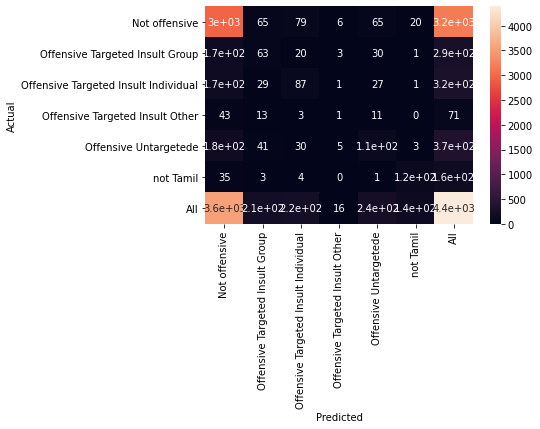

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


confusion_matrix = pd.crosstab(df_result['actual_label'], df_result['predicted_label'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [54]:
def do(label):
  if(label == 'Not_offensive'):
    label = 0
  elif (label == 'Offensive_Untargetede'):
    label = 1
  elif (label == 'Offensive_Targeted_Insult_Group'):
    label = 2
  elif (label == 'Offensive_Targeted_Insult_Individual'):
    label = 3
  elif (label == 'not-Tamil'):
    label = 4
  else:
    label = 5

In [70]:
df_result['actual_label']

0                         Not offensive
1                         Not offensive
2                             not Tamil
3                         Not offensive
4                 Offensive Untargetede
                     ...               
4386    Offensive Targeted Insult Group
4387                          not Tamil
4388                      Not offensive
4389                      Not offensive
4390    Offensive Targeted Insult Group
Name: actual_label, Length: 4391, dtype: object

In [73]:
encode_dict = {'Not offensive':0,'Offensive Untargetede':1,'Offensive Targeted Insult Group':2,'Offensive Targeted Insult Individual':3,'not Tamil':4, 'Offensive Targeted Insult Other':5}

def encode_cat(x):
  # if x not in encode_dict.keys():
  #   encode_dict[x] = len(encode_dict) 
  return encode_dict[x]
df_result['actual_label'] = df_result['actual_label'].apply(lambda x: encode_cat(x))
df_result['predicted_label'] = df_result['predicted_label'].apply(lambda x: encode_cat(x))

In [68]:
print(encode_dict)

{'Not offensive': 0, 'not Tamil': 1, 'Offensive Untargetede': 2, 'Offensive Targeted Insult Group': 3, 'Offensive Targeted Insult Other': 4, 'Offensive Targeted Insult Individual': 5}


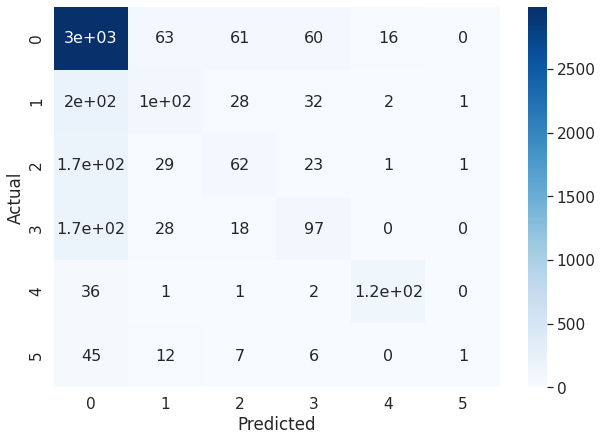

In [74]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



data = confusion_matrix(df_result['actual_label'], df_result['predicted_label'])
df_cm = pd.DataFrame(data, columns=np.unique(df_result['actual_label']), index = np.unique(df_result['actual_label']))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
df['text'] = df['text'].apply(lambda x: preprocess(x))

In [56]:
df_result['actual_label']

0       None
1       None
2       None
3       None
4       None
        ... 
4386    None
4387    None
4388    None
4389    None
4390    None
Name: actual_label, Length: 4391, dtype: object